# What does it take to write a systematic finite element program?
# Break everthing we know about the problem down to a function!
--------------------
## Lets write a FEM program that solve the following problem
## Consider a bar that is clamped at $x=0$ and loaded by a force $F=1000$ N (in the positive x-direction) at the right edge $x=1.0$.
## The area of the bar changes with $x$ and is given by $A(x) = 0.0002 - 0.0001x\;m^2$.
## The bar has a Young's modulus of $E=210$ GPa.

### Construct a function that returns the Constitutive relationship of the 1D problem. The Youngs modulus of the Bar is 210 GPa

In [21]:
import numpy as np

def C(xi,local_coords):
    C_val = 210e9
    return C_val

### Determine functions that return the shape function values for a given value of $\xi$

In [22]:
def N1(xi):
    N_1 = -0.5*xi*(1-xi)
    return N_1

def N2(xi):
    N_2 = 0.5*xi*(1+xi)
    return N_2

def N3(xi):
    N_3 = (1-xi)*(1+xi)
    return N_3


In [23]:
def N1(xi):
    N_1 = -0.5*xi*(1-xi)
    return N_1

def N2(xi):
    N_2 = 0.5*xi*(1+xi)
    return N_2

def N3(xi):
    N_3 = (1-xi)*(1+xi)
    return N_3

### Construct functions that return the values of the derivatives of the shape functions as a function of $\xi$.


In [24]:
def dN1(xi):
    dN_1 = xi-0.5
    return dN_1

def dN2(xi):
    dN_2 = xi + 0.5
    return dN_2

def dN3(xi):
    dN_3 = -2*xi
    return dN_3

### Construct a function that returns the mapping between x and $\xi$, which takes $\xi$ and the local coordinates of the nodes as inputs.

In [25]:
def x(xi,loc_coords):
    x_xi = N1(xi)*loc_coords[0,0] + N2(xi)*loc_coords[0,1] + N3(xi)*loc_coords[0,2]
    return x_xi 

### Construct a function that returns the local displacement field as a function of $\xi$ and the local nodal displacements.

In [26]:
def u(xi,q):
    u_xi = N1(xi)*q[0,0] + N2(xi)*q[0,1] + N3(xi)*q[0,2]
    return u_xi 

### Setup the derivative of shape functions vector as a function of $\xi$.

In [27]:
def dN(z):
    dN_vec = np.array([[dN1(z),dN2(z),dN3(z)]])
    return dN_vec

### Setup dxdz function

In [50]:
def dxdxi(xi,local_coords):
    dxdz_val = np.dot(dN(xi),local_coords.T)
    return dxdz_val

### Setup B vector

In [51]:
def B(xi,local_coords):
    B_vec = 1/dxdxi(xi,local_coords)*dN(xi)
    return B_vec

### Define the area in local coordinates

In [52]:
def A(xi,local_coords):
    A_val = 0.0002 - 0.0001*x(xi,local_coords)
    return A_val

### Contstruct a function that returns the term to be integrated in the $\xi$ domain, for the stiffness matrix K, use $E = 210\cdot 10^9$. The inputs to the function are the $\xi$ values and the local node coordinates.


In [53]:
import numpy as np
import sympy as sp

def K_term(xi,local_coords):
    term = B(xi,local_coords)*C(xi,local_coords)*B(xi,local_coords).T*A(xi,local_coords)*dxdxi(xi,local_coords)
    return term

### Construct a function that calls the term function and itegrates it using an appropriate gauss quadrature rule to create the local stiffness matrix. Inputs are the local node coordinates.



In [54]:
import numpy as np
import sympy as sp

values = np.array([[0,0,0,0,0],[-1/np.sqrt(3),1/np.sqrt(3),0,0,0],[-3409/4401,0,3409/4401,0,0],
                  [-4744/5509,-8609/25322,8609/25322,4744/5509,0],
                  [-7669/8463,-5333/9904,0,5333/9904,7669/8463]])
weights = np.array([[2,0,0,0,0],[1,1,0,0,0],[5/9,8/9,5/9,0,0],
                   [3681/10582,6901/10582,6901/10582,3681/10582,0],
                   [956/4035,1075/2246,128/225,1075/2246,956/4035]])


def K_local_func(local_node_coordinates):
    sum_t = np.zeros((3,3))
    gaussian_quadrature_pts = 3
    g_ind = gaussian_quadrature_pts - 1

    for i in range(gaussian_quadrature_pts):
        sum_t = sum_t + weights[g_ind,i]*K_term(values[g_ind,i],local_node_coordinates)
        
    K_local = sum_t
    return K_local

### Construct a function which accepts a global as well as local stiffness matrix of a given size and assembles the local stiffness matrix into the global stiffness matrix at the corresponding global coordinates. The function then returns the newly assembled global stiffness matrix.

In [55]:
def K_assemble(K_global,K_local,local_inds,element_no):
    for j in range(3):
            j_global = element_no*2 + j
            for k in range(3):
                k_global = element_no*2 + k
                K_global[j_global,k_global] = K_global[j_global,k_global] + K_local[local_inds[j],local_inds[k]]
    
    return K_global

### Construct a function that given the global nodal coordinates, loops throught the number of elements, calls the local K function for each element and uses the assembly function to construct the global stiffness matrix. Remember to accomodate the local coordinate notation convention.

In [56]:
import numpy as np
import sympy as sp

def K_global_func(no_elements,global_node_coordinates):
    
    no_nodes = np.max(np.shape(global_node_coordinates))
    
    K_global = np.zeros((no_nodes,no_nodes))
    local_inds = np.array([0,2,1])
    
    for e in range(no_elements):
        coords = global_node_coordinates[e*2:e*2+3]
        local_node_coordinates = np.array([coords[local_inds]])        
        K_local = K_local_func(local_node_coordinates)
        K_global = K_assemble(K_global,K_local,local_inds,e)
                
    return K_global
                

### Construct a function that defines the boundary conditions and solves for the displacements. The inputs are the number of elements and the global nodal coordinates. Call the function to construct the global stiffness matrix K and separate it into the free, prescribed and combined components. Solve for the free degrees of freedom and assemble the global displacement vector.

In [57]:
import numpy as np
import sympy as sp

def problem_def_solveU(no_elements,global_node_coordinates):
    F = 1000
    
    # loadings info
    A_end = 0.0002 - 0.0001*global_node_coordinates[-1]
    t1 = F/(A_end)

    no_nodes = np.max(np.shape(global_node_coordinates))
   #pts = gaussian_quadrature_pts - 1
    
    K_global = K_global_func(no_elements,global_node_coordinates)
    
    F_global = np.zeros((no_nodes,1))
    U_global = np.zeros((no_nodes,1))
    
    U_global[0] = 0
    F_global[no_nodes-1] = t1*A_end
    
    Kpp = K_global[0,0]
    Kfp = K_global[0,1:no_nodes]
    Kff = K_global[1:no_nodes,1:no_nodes]

    Fp = F_global[1:no_nodes,0] - Kfp*U_global[1:no_nodes,0]

    Uf = np.linalg.solve(Kff,Fp)
    U_global[1:no_nodes,0] = Uf[:]
    return U_global

### Construct a function which takes as inputs the field resolution per element, the local coordinates and the local nodal displacements and calculates the elements strain, stress, and displacement fields with their respective field coordinates in x.

In [58]:
def element_fields(res_per_element,local_coords,q):
    
    el_epsilon_field = np.zeros((res_per_element,1))
    el_sigma_field = np.zeros((res_per_element,1))
    el_disp_field = np.zeros((res_per_element,1))
    el_field_coords = np.zeros((res_per_element,1))
    
    xis = np.linspace(-1,1,res_per_element)
    for pt in range(res_per_element):
        xi = xis[pt]
        el_eps = np.dot(B(xi,local_coords),q.T)
        el_epsilon_field[pt,0] = el_eps
        el_sigma_field[pt,0] = el_eps*C(xi,local_coords)
        el_disp_field[pt,0] = u(xi,q)
        el_field_coords[pt,0] = x(xi,local_coords)
        
    return el_epsilon_field, el_sigma_field, el_disp_field, el_field_coords


### Construct a function which takes the solved displacements, the nodal coordinates, the number of elements and a prescribed resolution per element, calls the element fields function and assembles the displacement, strain and stress fields with their own respective coordinates in over the whole domain of the structure.

In [59]:
# Post-processing parameters
#magnification = 1e3

def global_fields(U_global,res_per_element,no_elements,global_node_coordinates):
    
    epsilon_field = np.zeros((no_elements*res_per_element,1))
    sigma_field = np.zeros((no_elements*res_per_element,1))
    disp_field = np.zeros((no_elements*res_per_element,1))
    field_coords = np.zeros((no_elements*res_per_element,1))
    
    for e in range(no_elements):
        
        local_inds = np.array([0,2,1])
        coords = global_node_coordinates[e*2:e*2+3]
        local_coords = np.array([coords[local_inds]])
        
        q_st = np.array([U_global[e*2:e*2+3,0]])
        q = np.array([q_st[0,local_inds]])
        el_epsilon_field, el_sigma_field, el_disp_field, el_field_coords = element_fields(res_per_element,local_coords,q)
        
        epsilon_field[e*res_per_element:(e+1)*res_per_element,0] = el_epsilon_field[:,0]
        sigma_field[e*res_per_element:(e+1)*res_per_element,0] = el_sigma_field[:,0]
        disp_field[e*res_per_element:(e+1)*res_per_element,0] = el_disp_field[:,0]
        field_coords[e*res_per_element:(e+1)*res_per_element,0] = el_field_coords[:,0]
    
    return disp_field, epsilon_field, sigma_field, field_coords

### Construct a function which calls up the given FEM problem in its entirety, taking only the number of elements prescribed as an input and returning: The global nodal coordinates as well as their deformed coordinates, the global nodal displacements, the displacement field, the strain field and the stress field.

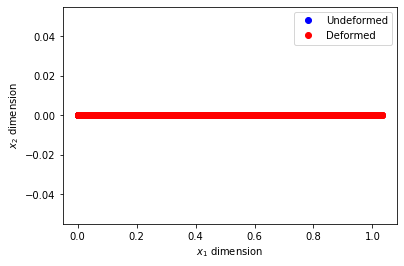

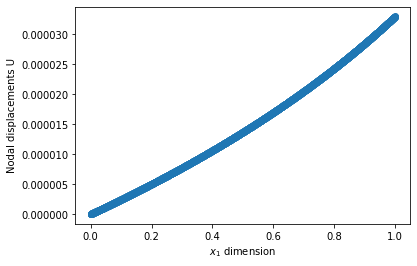

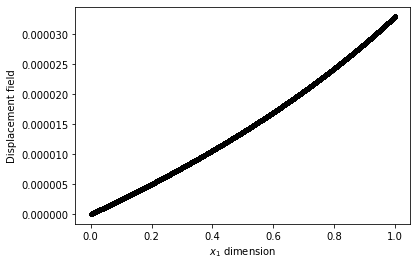

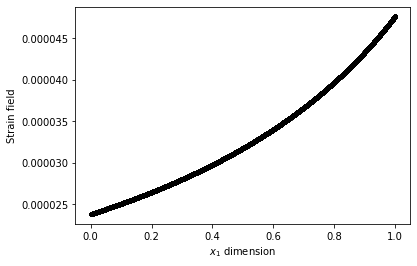

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


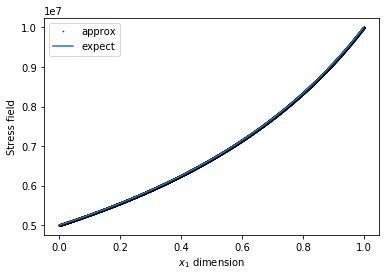

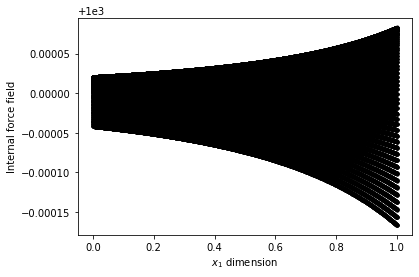

In [73]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def FEM_problem(no_elements):
    res_per_element = 101 # resolution of points sampled in the xi domain for the field of each element
    magnification_factor = 1e3 # magnification factor to be used with the nodal displacements for visualization
    
    x_length = 1.0
    no_nodes = no_elements*2 + 1
    global_node_coordinates = np.linspace(0,x_length,no_nodes)

    U_global = problem_def_solveU(no_elements,global_node_coordinates)
    disp_field, epsilon_field, sigma_field, field_coords = global_fields(U_global,res_per_element,no_elements,global_node_coordinates)
    
    gnc_def = global_node_coordinates + magnification_factor*U_global.T
    
    return global_node_coordinates, gnc_def, U_global, disp_field, epsilon_field, sigma_field, field_coords

# Select the number of elements: 1, 2, 4, 8, 16 
no_elements = 1000

global_node_coordinates, gnc_def, U_global, disp_field, epsilon_field, sigma_field, field_coords = FEM_problem(no_elements)
no_nodes = np.max(np.shape(global_node_coordinates))
ys = np.zeros((no_nodes,1))
    
plt.figure(1)
plt.plot(global_node_coordinates,ys,'bo',label='Undeformed')
plt.plot(gnc_def.T,ys,'ro',label='Deformed')
plt.xlabel("$x_1$ dimension")
plt.ylabel("$x_2$ dimension")
plt.legend()

plt.figure(2)
plt.plot(global_node_coordinates,U_global,'o')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Nodal displacements U")

plt.figure(3)
plt.plot(field_coords,disp_field,'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Displacement field")

plt.figure(4)
plt.plot(field_coords,epsilon_field,'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Strain field")

plt.figure(5)
plt.plot(field_coords,sigma_field,'k.',label='approx',markersize=1)
plt.plot(field_coords,1000/(0.0002-field_coords*0.0001),label='expect')
plt.legend()
plt.xlabel("$x_1$ dimension")
plt.ylabel("Stress field")

plt.figure(6)
plt.plot(field_coords,sigma_field*(0.0002-field_coords*0.0001),'k.')
plt.xlabel("$x_1$ dimension")
plt.ylabel("Internal force field")
plt.show()

# Why are there commercial packages if I can write my own FEM programme?

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.finiteelementanalysis.com.au/wp-content/uploads/2014/10/Pic_15.jpg")        

In [36]:
Image(url= "https://www.finiteelementanalysis.com.au/wp-content/uploads/2014/10/Pic_17.jpg")

In [37]:
Image(url= "https://www.finiteelementanalysis.com.au/wp-content/uploads/2014/10/Pic_16.jpg")

## Verification and Validation V&V (NAFEMS)
## What is V&V? Download and Read the Following
## https://www.nafems.org/downloads/North_America/what_is_v_and_v_dec_09/nafems_vv_webinar_december_09_final.pdf
# NAFEMS International Association Engineering Modelling
## https://www.nafems.org/
